In [1]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import re
% matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

#pickle to load model
import pickle
import time

import spacy
nlp = spacy.load('en_core_web_lg')

from gensim.models import Phrases
from gensim.models.phrases import Phraser


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [3]:
# Update puncuation list in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_punct = True

link for our dataset : https://www.kaggle.com/c/fake-news/data

label: a label that marks the article as potentially unreliable

1: unreliable

0: reliable

In [2]:
import pandas as pd

In [3]:
df_train = pd.read_csv("./data/train.csv",encoding = "utf8")

In [4]:
df_train[df_train['label']==1].shape

(10413, 5)

In [9]:
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [15]:
df_train.shape

(20800, 5)

## Analyze data

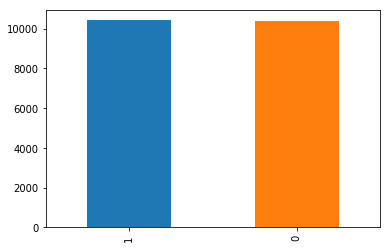

In [16]:
df_train.label.value_counts().plot(kind='bar')


-> Le nombre de fake news est égal à celui de real 

In [ ]:
#extract fake news
fake_news = df_train[df_train["label"] == 1]

#extract real news
real_news = df_train[df_train["label"] == 0]

###### Show most important words in fake news 

In [41]:
# Convert text and response to array 
x_text_fake = fake_news.text.values


In [42]:
import nltk
words = nltk.word_tokenize(" ".join(x_text_fake.tolist()))

In [43]:
from nltk.corpus import stopwords
import string

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('english') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]




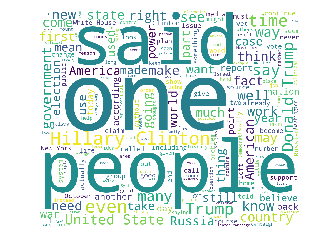

In [44]:
from wordcloud import WordCloud, STOPWORDS

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(" ".join(cleanwords))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()


###### Show most important words in real news 

In [45]:
x_text_real = real_news.text.values

In [47]:
words = nltk.word_tokenize(" ".join(x_text_real.tolist()))

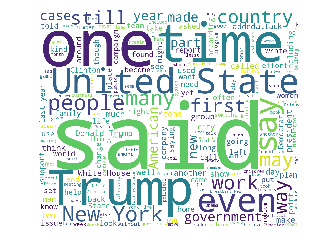

In [48]:
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(" ".join(cleanwords))


plt.imshow(wordcloud2)
plt.axis('off')
plt.show()


#### Show most common bigrams

In [49]:
bigrams = nltk.bigrams(cleanwords)

In [50]:
# look at the most common. 

from collections import Counter

counter = Counter(bigrams)
print(counter.most_common(10))

[(('United', 'States'), 8412), (('New', 'York'), 6498), (('Donald', 'Trump'), 4486), (('White', 'House'), 3918), (('last', 'year'), 2439), (('President', 'Trump'), 2243), (('said', 'The'), 2155), (('York', 'Times'), 1978), (('Islamic', 'State'), 1958), (('The', 'New'), 1809)]


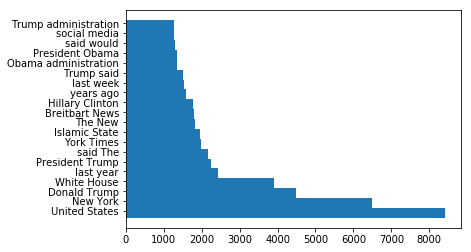

In [52]:
num_to_show = 20

labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
values = [e[1] for e in counter.most_common(num_to_show)]

indexes = np.arange(len(labels))
width = 1

#plt.bar(indexes, values, width)
#plt.xticks(indexes + width * 0.5, labels, rotation=90)

plt.barh(indexes, values, width)
plt.yticks(indexes + width * 0.2, labels)
plt.show()

#### Preprocessing functions

In [5]:
# Convert text and response to array 
x_text = df_train.text.values
y_response = df_train.label.values

In [6]:
# Remove twitter handles from text 
for idx in range(len(x_text)):
    x_text[idx] = re.sub(r'@([A-Za-z0-9_]+)', "", str(x_text[idx]))

In [7]:
# Remove hyperlinks from text
for idx in range(len(x_text)):
    x_text[idx] = re.sub(r"(https|http)\S+", "", str(x_text[idx]))

In [23]:
# helper function to eliminate tokens that are pure punctuation, whitespace, or stopword
# can be updated based on desired filtering 

def process_txt(token):
    return token.is_punct or token.is_space or token.is_stop or token.like_num

In [11]:
# function to take array of articles and turn them into nested list of tokens

def lemmatize_txt(array):
    lemma = []
    
    for doc in nlp.pipe(array, batch_size=50,
                        n_threads=-1):
        if doc.is_parsed:
            lemma.append([n.lemma_ for n in doc if not process_txt(n)])
        
        else:
            lemma.append(None)
    
    return lemma

# function to recombine nested list of tokens into full articles 

def lemma_combine(lis):
    parsed_articles = []
    
    for i in range(len(lis)):
        concat_art = ' '.join(lis[i])
        parsed_articles.append(concat_art)
    
    return parsed_articles

# function to match "cleaned" text back up with response variable

def zip_response(observations, response):
    response = response.tolist()
    
    return list(zip(observations, response))

### Process text

In [ ]:
# Create nested list of tokens for each article
lem = lemmatize_txt(x_text)

# Create bi-grams for our text 
phrases = Phrases(lem)
bigram = Phraser(phrases)
bigram_lem = list(bigram[lem])

# Create tri-grams for our text
phrases2 = Phrases(bigram_lem)
trigram = Phraser(phrases2)
trigram_lem = list(trigram[bigram_lem])


In [54]:
len(lem)

20800

In [55]:
token_uni = "token_unigram_text"
fileObject = open(token_uni,'wb') 
pickle.dump(lem,fileObject)   
fileObject.close()


In [56]:
token_trigrams = "token_trigram_text"
fileObject = open(token_trigrams,'wb') 
pickle.dump(trigram_lem,fileObject)   
fileObject.close()

In [10]:
# Recombine full article text for unigrams, bigrams, and trigrams
uni_lem_comb = lemma_combine(lem)
bi_lem_comb = lemma_combine(bigram_lem)
tri_lem_comb = lemma_combine(trigram_lem)

NameError: name 'lemma_combine' is not defined

In [58]:


# Save processed text so it can be loaded later 
unigrams = "unigram_text"
fileObject = open(unigrams,'wb') 
pickle.dump(uni_lem_comb,fileObject)   
fileObject.close()

bigrams = "bigram_text"
fileObject = open(bigrams,'wb') 
pickle.dump(bi_lem_comb,fileObject)   
fileObject.close()

trigrams = "trigram_text"
# open the file for writing
fileObject = open(trigrams,'wb') 
pickle.dump(tri_lem_comb,fileObject)   
fileObject.close()

### Reload processed text

In [6]:
fileObject = open('unigram_text','rb')  
uni_lem_comb2 = pickle.load(fileObject)  

fileObject = open('bigram_text','rb')  
bi_lem_comb2 = pickle.load(fileObject)  

fileObject = open('trigram_text','rb')  
tri_lem_comb2 = pickle.load(fileObject)  

## Prepare Model With TF-IDF

### Naive Bayes

In [7]:
def evaluate_model(clf, actual, predicted):
    report = metrics.classification_report(actual, predicted, target_names = ["0", "1"])
    matrix = confusion_matrix(actual, predicted)
    train_loss = metrics.log_loss(y_train, clf.predict_proba(x_train))
    test_loss = metrics.log_loss(y_test, clf.predict_proba(x_test))
    
    print("Train score:", train_loss)
    print("Test score:", test_loss)
    print("Confusion Matrix\n", matrix)
    print("Classification Report:\n", report)
    
    return test_loss

In [8]:
x_train, x_test, y_train, y_test = train_test_split(tri_lem_comb2, y_response, test_size = 0.2, stratify = y_response)

In [9]:
test_data = "X_test_data.txt"
fileObject = open(test_data,'wb') 
pickle.dump(x_test,fileObject)   
fileObject.close()

y_test_data = "y_test_data.txt"
fileObject = open(y_test_data,'wb') 
pickle.dump(y_test,fileObject)   
fileObject.close()



In [66]:
len(x_train)

16640

In [67]:
len(y_train)

16640

### Naive Bayes Model

In [68]:
# Set up pipeline to run TFIDF and Naive Bayes
text_pipe_nb = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [69]:
text_pipe_nb.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [ ]:
'''
# a. extract .get_feature_names() to use as column names in the dataframe
feature_names = (
                text_pipe_nb.best_estimator_
                        .named_steps['vectorizer']
                        .get_feature_names()
                )    

# b. get the TFIDF vector
data2 = (
         text_pipe_nb.best_estimator_
                 .named_steps['vectorizer']
                 .fit_transform(raw_data)
        )

# put into a pandas dataframe
transformed = pd.DataFrame(data2, columns=feature_names)
'''

In [70]:
# Set up grid search to find best parameters for TFIDF and MN
# max_df : ignore all words that have appeared in % of the documents
parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'nb__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}

In [71]:
# Establish grid search instance
gs_nb = GridSearchCV(text_pipe_nb, parameters, n_jobs=-1, scoring = 'f1')

In [72]:
%%time 
# Fit grid search to train data and find best parameters
gs_nb = gs_nb.fit(x_train, y_train)

Wall time: 48min 53s


In [73]:
# Check best parameters
gs_nb.best_params_

{'nb__alpha': 1e-05, 'tfidf__max_df': 0.95, 'tfidf__min_df': 0.001}

In [74]:
# Predict on test data
nb_predicted = gs_nb.predict(x_test)

In [75]:
# Produce confusion matrix and classification report for nb model
evaluate_model(gs_nb, y_test, nb_predicted)

Train score: 0.11788072837072282
Test score: 0.16090531225248692
Confusion Matrix
 [[2019   58]
 [ 172 1911]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      2077
           1       0.97      0.92      0.94      2083

   micro avg       0.94      0.94      0.94      4160
   macro avg       0.95      0.94      0.94      4160
weighted avg       0.95      0.94      0.94      4160



0.16090531225248692

In [77]:
#Save Naive Bayes Model with TF-IDF
filename = './trained_models/nb_model_tfidf.sav'
pickle.dump(gs_nb, open(filename, 'wb'))


### Logistic Regression Model

In [79]:
text_pipe_lr = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [80]:
text_pipe_lr.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [81]:
# Set up grid search to find best parameters for TFIDF and LogReg
lr_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'lr__penalty': ('l1','l2'),\
                'lr__C': (0.01, 0.1, 1),\
                'lr__class_weight': (None, 'balanced')}

In [82]:
# Establish grid search instance for log reg
gs_lr = GridSearchCV(text_pipe_lr, lr_parameters, n_jobs=-1, scoring='f1')

In [ ]:
%%time 
# Fit grid search to train data and find best parameters
gs_lr = gs_lr.fit(x_train, y_train)

In [ ]:
# Get best parameters for log reg
gs_lr.best_params_

In [ ]:
# Predict on test data 
lr_predicted = gs_lr.predict(x_test)

In [ ]:
# Produce confusion matrix and classification report for lr model
evaluate_model(gs_lr, y_test, lr_predicted)

In [78]:
# Save Logistic regression model
filename = './trained_models/lr_model_tfidf.sav'
pickle.dump(gs_lr, open(filename, 'wb'))

NameError: name 'gs_lr' is not defined

### Random Forest

In [10]:
text_pipe_rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

In [11]:
text_pipe_rf.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [12]:
# Set up grid search to find best parameters for TFIDF and RF
rf_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'rf__n_estimators': (50, 100, 200),\
                'rf__criterion': ('gini', 'entropy'),\
                'rf__class_weight': (None, 'balanced'),\
                'rf__min_samples_split': (10,20,30)}

In [13]:
# Establish grid search instance for random forest
gs_rf = GridSearchCV(text_pipe_rf, rf_parameters, n_jobs=-1, scoring='f1')

In [ ]:
%%time 
# Fit grid search to train data and find best parameters
gs_rf = gs_rf.fit(x_train, y_train)

In [ ]:
# Get best parameters for log reg
gs_rf.best_params_

In [ ]:
# Predict on test data 
rf_predicted = gs_rf.predict(x_test)

In [123]:
evaluate_model(gs_rf, y_test, rf_predicted)

Train score: 0.5035659070562016
Test score: 0.6132820306821618
Confusion Matrix
 [[2 0]
 [0 2]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



0.6132820306821618

In [ ]:
# Save Random Forest model
filename = './trained_models/rf_model_tfidf.sav'
pickle.dump(gs_rf, open(filename, 'wb'))

### SVM Model

In [127]:
text_pipe_svm = Pipeline([('tfidf', TfidfVectorizer()), ('svm', SVC())])

In [128]:
text_pipe_svm.fit(x_train,y_train)

C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [129]:
# Set up grid search to find best parameters for TFIDF and SVM
svm_parameters = {'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              'tfidf__min_df': (0.001,0.01,0.1),\
              'svm__C': (1, 10, 100, 1000),\
                'svm__degree': (1 , 2, 3),\
                'svm__class_weight': (None, 'balanced')}

In [130]:
# Establish grid search instance for SVM
gs_svm = GridSearchCV(text_pipe_svm, svm_parameters, n_jobs=-1, scoring='f1')

In [131]:
%%time 
# Fit grid search to train data and find best parameters
gs_svm = gs_svm.fit(x_train, y_train)

C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\DELL\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 11 s


In [132]:
# Get best parameters for SVM
gs_svm.best_params_

{'svm__C': 1000,
 'svm__class_weight': None,
 'svm__degree': 1,
 'tfidf__max_df': 1.0,
 'tfidf__min_df': 0.1}

In [133]:
# Predict on test data 
svm_predicted = gs_svm.predict(x_test)

In [ ]:
evaluate_model(gs_svm, y_test, svm_predicted)

In [ ]:
# Save Random Forest model
filename = './trained_models/svm_model_tfidf.sav'
pickle.dump(gs_svm, open(filename, 'wb'))

## Prepare Model With Word2Vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
fileObject = open('unigram_text','rb')  
uni_lem_comb2 = pickle.load(fileObject)  

fileObject = open('bigram_text','rb')  
bi_lem_comb2 = pickle.load(fileObject)  

fileObject = open('trigram_text','rb')  
tri_lem_comb2 = pickle.load(fileObject)  

In [ ]:
articles_lines = list()
lines = df_train['text'].values.tolist()
EMBEDDING_DIM = 100
for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    articles_lines.append(words)
    
model = gensim.models.Word2Vec(sentences=articles_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)    

#### Convert Text into Vectors

In [ ]:
def infer_vector(text):
    text = text.split()
    vector = []
    for i in text:
        try:
            vector.append(model.word_vec(i))
        except:
            pass
    return list(np.mean(vector, axis=0))

In [ ]:
vec_text = df_train.text.apply(infer_vector)


In [ ]:
# saving vec_text of trigrams:
filename = 'vec_text_trigram.sav'
pickle.dump(vec_text, open(filename, 'wb'))

In [ ]:
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(vec_text, y_response, test_size = 0.2, stratify = y_response)

### Logistic Regression with Word2Vec

In [ ]:
lr = LogisticRegression()

%%time
lr.fit(x_train_w, y_train_w)

In [ ]:
lr_parameters = {#'tfidf__max_df': (0.75, 0.80, 0.85, 0.90, 0.95, 1.0),\
              #'tfidf__min_df': (0.001,0.01,0.1),\
               'penalty': ('l1','l2'),\
               'C': (0.01, 0.1, 1),\
               'class_weight': (None, 'balanced')}

In [ ]:
# Establish grid search instance
wv_lr = GridSearchCV(lr, lr_parameters, n_jobs=-1, scoring = 'f1')

In [ ]:
%%time
wv_lr = wv_lr.fit(x_train_w, y_train_w)

In [ ]:
wv_lr.best_params_

In [ ]:
lr_predicted = wv_lr.predict(x_test_w)

In [ ]:
%%time
# Get more detailed performance metrics
evaluate_model(wv_lr, y_test_w, lr_predicted)

In [ ]:
# saving lr model with word2vec
filename = './trained_models/w2v_lr_model.sav'
pickle.dump(wv_lr, open(filename, 'wb'))

### Random Forest Model with Word2Vec

In [ ]:
rf = RandomForestClassifier()

In [ ]:
%%time
rf.fit(x_train_w, y_train_w)

In [ ]:
rf_parameters = {'n_estimators': (50, 100, 200),\
               'criterion': ('gini', 'entropy'),\
               'class_weight': (None, 'balanced'),\
               'min_samples_split': (10,20,30)}

In [ ]:
wv_rf = GridSearchCV(rf, rf_parameters, n_jobs=-1, scoring='f1')

In [ ]:
wv_rf.best_params_
%%time
rf_predicted = wv_rf.predict(x_test_w)

In [ ]:
%%time
# Get more detailed performance metrics
evaluate_model(wv_rf, y_test_w, rf_predicted)

In [ ]:
# saving svm model
filename = './trained_models/w2v_rf_model.sav'
pickle.dump(wv_rf, open(filename, 'wb'))

### SVM Model with Word2Vec

In [ ]:
svm = SVC()

In [ ]:
%%time
svm.fit(x_train_w, y_train_w)

In [ ]:
svm_parameters = {'C': (1, 10, 100, 1000),\
                 'degree': (1, 2, 3),\
                 'class_weight': (None, 'balanced')}

In [ ]:
wv_svm = GridSearchCV(svm, svm_parameters, n_jobs=-1, scoring='f1')

In [ ]:
%%time
wv_svm = wv_svm.fit(x_train_w, y_train_w)

In [ ]:
wv_svm.best_params_

In [ ]:
svm_predicted = wv_svm.predict(x_test_w)

In [ ]:
# can't feed in proba for svm, log loss requires probability
matrix = confusion_matrix(y_test, svm_predicted)
report = metrics.classification_report(y_test_w, svm_predicted, target_names = ['0', '1'])
print('Confusion Matrix:\n', matrix)
print('Classification report:\n', report)